In [7]:
#import thư viện 
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import os 
print(f"Đã import các thư viện cần thiết")

Đã import các thư viện cần thiết


In [8]:
#Định nghĩa cấu hình thiết bị
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif device.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# Định nghĩa Hyperparameters
batch_size = 64
num_epochs = 50    # Số epochs huấn luyện
learning_rate = 0.001  #tốc độ học 
noise_factor = 0.3      # Độ mạnh của nhiễu Gaussian
data_dir = './data'      # Thư mục lưu dữ liệu MNIST

print(f"Sử dụng thiết bị: {device}")
print(f"Batch Size: {batch_size}")
print(f"Số Epochs: {num_epochs}")
print(f"Learning Rate: {learning_rate}")
print(f"Noise Factor: {noise_factor}")
print(f"Thư mục dữ liệu: {data_dir}")

# Tạo thư mục data nếu chưa tồn tại
os.makedirs(data_dir, exist_ok=True)

Sử dụng thiết bị: mps
Batch Size: 64
Số Epochs: 50
Learning Rate: 0.001
Noise Factor: 0.3
Thư mục dữ liệu: ./data


In [9]:
#định nghĩa phép biến đổi ảnh
data_transform = transforms.Compose([
    transforms.ToTensor() 
])
print("Đã định nghĩa data transform (ToTensor).")

#tải Dataset MNIST
try:
    train_dataset = datasets.MNIST(root=data_dir, train=True, download=True, transform=data_transform)
    test_dataset = datasets.MNIST(root=data_dir, train=False, download=True, transform=data_transform)
    print("Tải/Kiểm tra dữ liệu MNIST thành công.")
except Exception as e:
    print(f"Lỗi khi tải MNIST: {e}. Vui lòng kiểm tra kết nối mạng hoặc thư mục DATA_DIR.")
    exit() 

Đã định nghĩa data transform (ToTensor).
Tải/Kiểm tra dữ liệu MNIST thành công.


In [10]:
#tạo DataLoader
train_loader = DataLoader(train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True, 
                          num_workers=0) 
test_loader = DataLoader(test_dataset, 
                         batch_size=batch_size, 
                         shuffle=False, 
                         num_workers=0)
print(f"Đã tạo DataLoader.")

#kiểm tra DataLoader
print("\n--- Kiểm tra DataLoader (Train) ---")
try:
    images_check, labels_check = next(iter(train_loader))
    print(f"Trạng thái: Lấy thành công 1 batch.")
    print(f"Kích thước batch ảnh: {images_check.size()}") 
    print(f"Kích thước batch nhãn: {labels_check.size()}") 
    print(f"Giá trị pixel ảnh: Min={images_check.min():.2f}, Max={images_check.max():.2f}") 
    print(f"==> Kiểm tra DataLoader thành công. ===")
except StopIteration:
     print("Lỗi: DataLoader rỗng.")
except Exception as e:
    print(f"Lỗi khi kiểm tra DataLoader: {e}")
print("-----------------------------")

Đã tạo DataLoader.

--- Kiểm tra DataLoader (Train) ---
Trạng thái: Lấy thành công 1 batch.
Kích thước batch ảnh: torch.Size([64, 1, 28, 28])
Kích thước batch nhãn: torch.Size([64])
Giá trị pixel ảnh: Min=0.00, Max=1.00
==> Kiểm tra DataLoader thành công. ===
-----------------------------


In [11]:

#khởi tạo mô hình
print("\n---Định nghĩa Mô hình ConvDenoiser ---")
class ConvDenoiser(nn.Module):
    def __init__(self):
        super().__init__()
        #Encoder
        self.encoder = nn.Sequential(
            #Block1
            nn.Conv2d(1, 16, kernel_size=3, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),      
            #Block2           
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2)                  
        )
        #Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=2, stride=2),
            nn.Sigmoid()
        )
        print("Khởi tạo ConvDenoiser.")

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Khởi tạo model và chuyển lên device
model = ConvDenoiser().to(device)
print(model)



---Định nghĩa Mô hình ConvDenoiser ---
Khởi tạo ConvDenoiser.
ConvDenoiser(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
    (3): Sigmoid()
  )
)



--- 4. Thiết lập Huấn luyện ---
Sử dụng hàm Loss: MSELoss
Sử dụng Optimizer: Adam với learning rate 0.001

--- Bắt đầu Huấn luyện ---


Epoch 1/50: 100%|██████████| 938/938 [00:13<00:00, 68.40it/s, loss=0.046350]


Epoch [1/50] - Average Training Loss: 0.060701


Epoch 2/50: 100%|██████████| 938/938 [00:10<00:00, 85.45it/s, loss=0.047669]


Epoch [2/50] - Average Training Loss: 0.043072


Epoch 3/50: 100%|██████████| 938/938 [00:11<00:00, 83.63it/s, loss=0.041513]


Epoch [3/50] - Average Training Loss: 0.042236


Epoch 4/50: 100%|██████████| 938/938 [00:11<00:00, 83.83it/s, loss=0.040985]


Epoch [4/50] - Average Training Loss: 0.041884


Epoch 5/50: 100%|██████████| 938/938 [00:11<00:00, 83.22it/s, loss=0.040261]


Epoch [5/50] - Average Training Loss: 0.041571


Epoch 6/50: 100%|██████████| 938/938 [00:11<00:00, 84.21it/s, loss=0.042964]


Epoch [6/50] - Average Training Loss: 0.041451


Epoch 7/50: 100%|██████████| 938/938 [00:10<00:00, 85.72it/s, loss=0.040237]


Epoch [7/50] - Average Training Loss: 0.041157


Epoch 8/50: 100%|██████████| 938/938 [00:11<00:00, 82.82it/s, loss=0.041725]


Epoch [8/50] - Average Training Loss: 0.041000


Epoch 9/50: 100%|██████████| 938/938 [00:11<00:00, 84.12it/s, loss=0.041251]


Epoch [9/50] - Average Training Loss: 0.040730


Epoch 10/50: 100%|██████████| 938/938 [00:10<00:00, 87.12it/s, loss=0.039982]


Epoch [10/50] - Average Training Loss: 0.040571


Epoch 11/50: 100%|██████████| 938/938 [00:10<00:00, 87.23it/s, loss=0.040937]


Epoch [11/50] - Average Training Loss: 0.040546


Epoch 12/50: 100%|██████████| 938/938 [00:10<00:00, 87.87it/s, loss=0.037837]


Epoch [12/50] - Average Training Loss: 0.040365


Epoch 13/50: 100%|██████████| 938/938 [00:10<00:00, 87.77it/s, loss=0.041007]


Epoch [13/50] - Average Training Loss: 0.040337


Epoch 14/50: 100%|██████████| 938/938 [00:11<00:00, 84.41it/s, loss=0.041184]


Epoch [14/50] - Average Training Loss: 0.040277


Epoch 15/50: 100%|██████████| 938/938 [00:11<00:00, 84.98it/s, loss=0.040014]


Epoch [15/50] - Average Training Loss: 0.040177


Epoch 16/50: 100%|██████████| 938/938 [00:10<00:00, 87.48it/s, loss=0.039721]


Epoch [16/50] - Average Training Loss: 0.040131


Epoch 17/50: 100%|██████████| 938/938 [00:11<00:00, 84.84it/s, loss=0.039915]


Epoch [17/50] - Average Training Loss: 0.040040


Epoch 18/50: 100%|██████████| 938/938 [00:10<00:00, 86.46it/s, loss=0.037443]


Epoch [18/50] - Average Training Loss: 0.039974


Epoch 19/50: 100%|██████████| 938/938 [00:10<00:00, 86.47it/s, loss=0.040626]


Epoch [19/50] - Average Training Loss: 0.039984


Epoch 20/50: 100%|██████████| 938/938 [00:10<00:00, 86.29it/s, loss=0.041264]


Epoch [20/50] - Average Training Loss: 0.039949


Epoch 21/50: 100%|██████████| 938/938 [00:10<00:00, 87.10it/s, loss=0.039621]


Epoch [21/50] - Average Training Loss: 0.039904


Epoch 22/50: 100%|██████████| 938/938 [00:10<00:00, 88.33it/s, loss=0.041122]


Epoch [22/50] - Average Training Loss: 0.039823


Epoch 23/50: 100%|██████████| 938/938 [00:10<00:00, 87.20it/s, loss=0.038465]


Epoch [23/50] - Average Training Loss: 0.039770


Epoch 24/50: 100%|██████████| 938/938 [00:10<00:00, 88.53it/s, loss=0.040420]


Epoch [24/50] - Average Training Loss: 0.039771


Epoch 25/50: 100%|██████████| 938/938 [00:10<00:00, 85.62it/s, loss=0.037474]


Epoch [25/50] - Average Training Loss: 0.039750


Epoch 26/50: 100%|██████████| 938/938 [00:10<00:00, 86.37it/s, loss=0.038180]


Epoch [26/50] - Average Training Loss: 0.039669


Epoch 27/50: 100%|██████████| 938/938 [00:10<00:00, 87.20it/s, loss=0.042980]


Epoch [27/50] - Average Training Loss: 0.039680


Epoch 28/50: 100%|██████████| 938/938 [00:10<00:00, 86.32it/s, loss=0.039068]


Epoch [28/50] - Average Training Loss: 0.039667


Epoch 29/50: 100%|██████████| 938/938 [00:10<00:00, 86.77it/s, loss=0.041676]


Epoch [29/50] - Average Training Loss: 0.039630


Epoch 30/50: 100%|██████████| 938/938 [00:10<00:00, 86.86it/s, loss=0.039527]


Epoch [30/50] - Average Training Loss: 0.039608


Epoch 31/50: 100%|██████████| 938/938 [00:10<00:00, 85.92it/s, loss=0.037538]


Epoch [31/50] - Average Training Loss: 0.039657


Epoch 32/50: 100%|██████████| 938/938 [00:10<00:00, 86.67it/s, loss=0.035967]


Epoch [32/50] - Average Training Loss: 0.039471


Epoch 33/50: 100%|██████████| 938/938 [00:11<00:00, 83.90it/s, loss=0.041161]


Epoch [33/50] - Average Training Loss: 0.039464


Epoch 34/50: 100%|██████████| 938/938 [00:12<00:00, 75.29it/s, loss=0.038266] 


Epoch [34/50] - Average Training Loss: 0.039508


Epoch 35/50: 100%|██████████| 938/938 [00:11<00:00, 78.89it/s, loss=0.038520]


Epoch [35/50] - Average Training Loss: 0.039503


Epoch 36/50: 100%|██████████| 938/938 [00:11<00:00, 83.07it/s, loss=0.038738]


Epoch [36/50] - Average Training Loss: 0.039427


Epoch 37/50: 100%|██████████| 938/938 [00:10<00:00, 87.42it/s, loss=0.036953]


Epoch [37/50] - Average Training Loss: 0.039490


Epoch 38/50: 100%|██████████| 938/938 [00:10<00:00, 85.72it/s, loss=0.041588]


Epoch [38/50] - Average Training Loss: 0.039421


Epoch 39/50: 100%|██████████| 938/938 [00:10<00:00, 86.62it/s, loss=0.037153]


Epoch [39/50] - Average Training Loss: 0.039359


Epoch 40/50: 100%|██████████| 938/938 [00:10<00:00, 86.14it/s, loss=0.041601]


Epoch [40/50] - Average Training Loss: 0.039340


Epoch 41/50: 100%|██████████| 938/938 [00:10<00:00, 86.18it/s, loss=0.038632]


Epoch [41/50] - Average Training Loss: 0.039370


Epoch 42/50: 100%|██████████| 938/938 [00:10<00:00, 86.12it/s, loss=0.038392]


Epoch [42/50] - Average Training Loss: 0.039256


Epoch 43/50: 100%|██████████| 938/938 [00:11<00:00, 81.43it/s, loss=0.036950]


Epoch [43/50] - Average Training Loss: 0.039325


Epoch 44/50: 100%|██████████| 938/938 [00:11<00:00, 82.57it/s, loss=0.036836]


Epoch [44/50] - Average Training Loss: 0.039330


Epoch 45/50: 100%|██████████| 938/938 [00:11<00:00, 81.86it/s, loss=0.041456]


Epoch [45/50] - Average Training Loss: 0.039294


Epoch 46/50: 100%|██████████| 938/938 [00:10<00:00, 86.60it/s, loss=0.039914]


Epoch [46/50] - Average Training Loss: 0.039353


Epoch 47/50: 100%|██████████| 938/938 [00:10<00:00, 85.36it/s, loss=0.038272]


Epoch [47/50] - Average Training Loss: 0.039261


Epoch 48/50: 100%|██████████| 938/938 [00:10<00:00, 86.55it/s, loss=0.039076]


Epoch [48/50] - Average Training Loss: 0.039261


Epoch 49/50: 100%|██████████| 938/938 [00:10<00:00, 86.81it/s, loss=0.040805]


Epoch [49/50] - Average Training Loss: 0.039252


Epoch 50/50: 100%|██████████| 938/938 [00:11<00:00, 84.80it/s, loss=0.035690]


Epoch [50/50] - Average Training Loss: 0.039193
 Huấn luyện hoàn tất


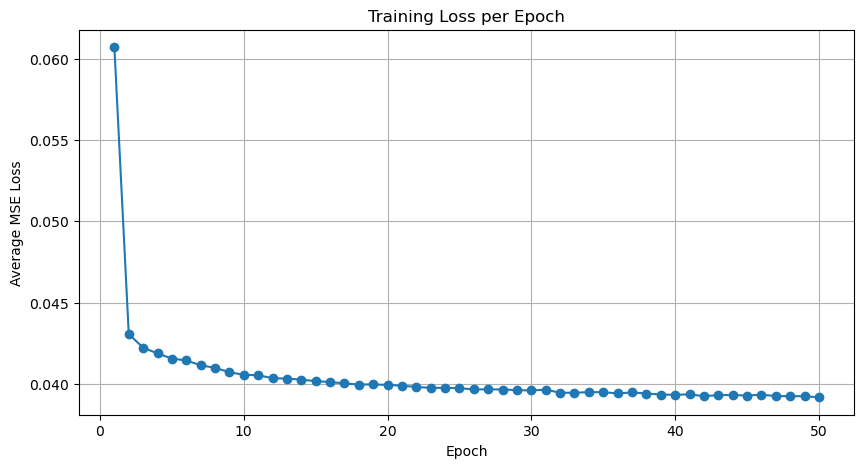

In [12]:
#huấn luyện mô hình
print("\n--- 4. Thiết lập Huấn luyện ---")

#định nghĩa hàm loss
criterion = nn.MSELoss() 
print(f"Sử dụng hàm Loss: MSELoss")

#định nghĩa optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
print(f"Sử dụng Optimizer: Adam với learning rate {learning_rate}")

#vòng lặp Huấn luyện
print("\n--- Bắt đầu Huấn luyện ---")
history = {'train_loss': []} 

for epoch in range(num_epochs):
    model.train() # Đặt model ở chế độ training
    epoch_loss = 0.0
    train_iterator = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=True)

    for data in train_iterator:
        clean_images, _ = data # Lấy ảnh sạch, bỏ qua nhãn
        clean_images = clean_images.to(device)

        #tạo ảnh nhiễu Gaussian 
        noise = torch.randn_like(clean_images) 
        noisy_images = torch.clamp(clean_images + noise, 0., 1.) # Cộng nhiễu và giữ trong [0, 1]
        noisy_images = noisy_images.to(device) 
        

        #forward pass
        outputs = model(noisy_images) 
        

        #tính loss
        loss = criterion(outputs, clean_images)
        

        #backward pass và optimizer
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        epoch_loss += loss.item()
        train_iterator.set_postfix(loss=f"{loss.item():.6f}")

    avg_epoch_loss = epoch_loss / len(train_loader)
    history['train_loss'].append(avg_epoch_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Average Training Loss: {avg_epoch_loss:.6f}")

print(f" Huấn luyện hoàn tất")

#vẽ đồ thị loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), history['train_loss'], marker='o', linestyle='-')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Average MSE Loss')
plt.grid(True)
plt.show()



Trực quan hóa kết quả trên tập Test ---


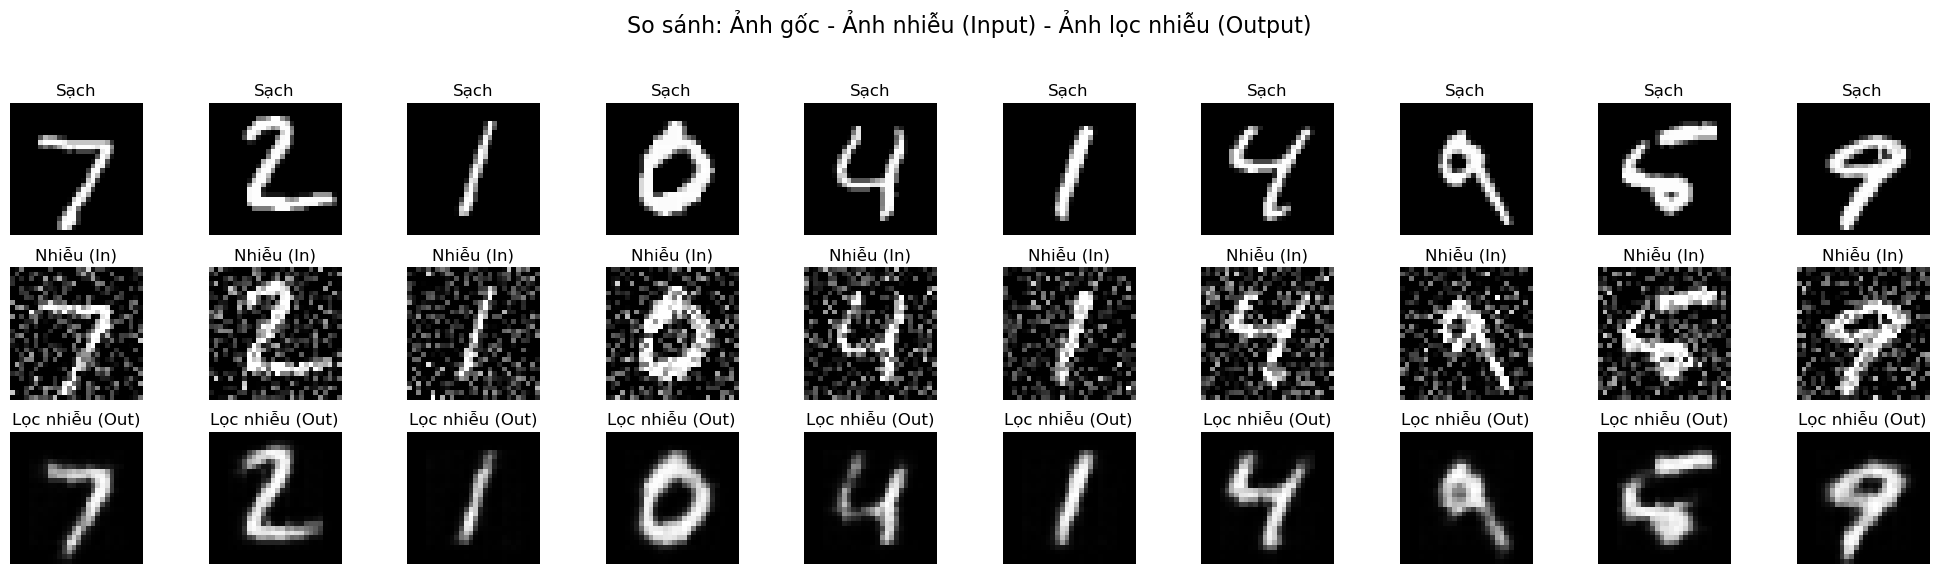

In [13]:
print("\nTrực quan hóa kết quả trên tập Test ---")
model.eval() #Chuyển model sang chế độ đánh giá

# Lấy một batch dữ liệu từ test_loader
try:
    test_iterator = iter(test_loader)
    clean_test_images, _ = next(test_iterator)
    clean_test_images = clean_test_images.to(device)
except StopIteration:
    print("Lỗi: Test loader rỗng.")
    clean_test_images = None # Đặt là None để xử lý ở dưới

if clean_test_images is not None:
    # Tạo nhiễu cho batch test (dùng cùng NOISE_FACTOR)
    noise = torch.randn_like(clean_test_images) * noise_factor
    noisy_test_images = torch.clamp(clean_test_images + noise, 0., 1.).to(device)

    # Chạy model để lọc nhiễu (không cần tính gradient)
    with torch.no_grad():
        denoised_test_images = model(noisy_test_images)

    # Chuyển dữ liệu về CPU và NumPy để hiển thị
    clean_np = clean_test_images.cpu().numpy()
    noisy_np = noisy_test_images.cpu().numpy()
    denoised_np = denoised_test_images.cpu().numpy()

    # Hiển thị ảnh
    n_display = 10 
    plt.figure(figsize=(20, 6)) 
    plt.suptitle("So sánh: Ảnh gốc - Ảnh nhiễu (Input) - Ảnh lọc nhiễu (Output)", fontsize=16)

    for i in range(min(n_display, len(clean_np))): 
        # Ảnh gốc sạch
        ax = plt.subplot(3, n_display, i + 1)
        plt.imshow(np.squeeze(clean_np[i]), cmap='gray') 
        ax.set_title("Sạch")
        ax.axis('off') 

        # Ảnh nhiễu (Input)
        ax = plt.subplot(3, n_display, i + 1 + n_display)
        plt.imshow(np.squeeze(noisy_np[i]), cmap='gray')
        ax.set_title("Nhiễu (In)")
        ax.axis('off')

        # Ảnh đã lọc nhiễu (Output)
        ax = plt.subplot(3, n_display, i + 1 + 2 * n_display)
        plt.imshow(np.squeeze(denoised_np[i]), cmap='gray')
        ax.set_title("Lọc nhiễu (Out)")
        ax.axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
    plt.show() 
else:
    print("Không thể trực quan hóa do lỗi khi lấy dữ liệu test.")

In [14]:
#lưu model
# print("\n--- Lưu Model ---")
save_path = 'conv_denoiser_mnist.pth'
torch.save(model.state_dict(), save_path)
print(f"Đã lưu model vào '{save_path}'")
print("\nChương trình Bài 3 hoàn tất.")

Đã lưu model vào 'conv_denoiser_mnist.pth'

Chương trình Bài 3 hoàn tất.
